In [1]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
import string
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense, Embedding, GlobalMaxPool1D
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, TextVectorization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

tf.keras.utils.set_random_seed(7)
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)
pd.set_option('max_colwidth', 600)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
pip install clean-text[gpl]


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 5.9 MB/s 
     |████████████████████████████████| 53 kB 1.4 MB/s 
     |████████████████████████████████| 235 kB 21.8 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=7acba10519bdecd2d677862607d99d36b4439f1f7df6c6d275cc4ea3fd3f3b8a
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [3]:
from cleantext import clean

In [4]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.0


In [5]:
print("Keras version: ", keras.__version__)

Keras version:  2.8.0


In [6]:
#mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
path_to_csv = '/content/gdrive/My Drive/Colab Notebooks/MSDS_458_Assignment_4/cyberbullying_tweets.csv'
df=pd.read_csv(path_to_csv)

# Cleaning and Organizing Data

In [8]:
#looking at original data observations with emojis and URLs

df.iloc[[706,1040]]

,tweet_text,cyberbullying_type
706,Uh. Why do they not make these for grownups? http://t.co/rHDOkljnDI,not_cyberbullying
1040,OMG 😱 I have a feeling I’m going to be overwhelmed 😱 by my emoticons in tomorrow’s #mkr 😱😰😅😜😀😩😨😱😱,not_cyberbullying


In [9]:
#function for cleaning data by removing emojies and urls with clean-text library. https://pypi.org/project/clean-text/

def cleaning_tweet_text(text):
    text= clean(text, no_emoji=True, no_urls=True, replace_with_url="") #removing emojies and urls 
    return text



In [10]:
#applying cleaning function to tweets
df["tweet_text"]=df["tweet_text"].apply(cleaning_tweet_text)

In [11]:
#dropping duplicates
df = df.drop_duplicates(subset=['tweet_text'], keep='last')
df.shape

(45603, 2)

In [12]:
#checking the same observations as above after removing emojies and urls. We can see there are no longer
#any emojis or urls
df.iloc[[706,1040]]

,tweet_text,cyberbullying_type
875,@adagrahamx3 better go to class today !,not_cyberbullying
1297,"eli best rap album iceprince, not sentimental at all. its worth it",not_cyberbullying


In [13]:
#checking distribution of cyberbyllying lables.
df["cyberbullying_type"].value_counts()

religion               7974
age                    7952
ethnicity              7946
other_cyberbullying    7720
gender                 7651
not_cyberbullying      6360
Name: cyberbullying_type, dtype: int64

In [14]:
#creating column of numerical cyberbullying labels.

label_number_mappings={"religion":0,
                       "age":1,
                       "gender":2,
                       "ethnicity":3,
                       "not_cyberbullying":4,
                       "other_cyberbullying":5
                      }
df["label_values"]=df["cyberbullying_type"].map(label_number_mappings)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [15]:
#checking if mapping was properly done
df["label_values"].value_counts()

0    7974
1    7952
3    7946
5    7720
2    7651
4    6360
Name: label_values, dtype: int64

In [16]:
#Splitting dataset into full_train and test sets, stratifying on labels.

X_train_full, X_test, y_train_full, y_test = train_test_split(df["tweet_text"], df["label_values"], test_size=5000, stratify=df["label_values"])

In [17]:
#making sure full train set is stratified properly
y_train_full.value_counts()

0    7100
1    7080
3    7075
5    6873
2    6812
4    5663
Name: label_values, dtype: int64

In [18]:
#making sure test set is stratified properly
y_test.value_counts()

0    874
1    872
3    871
5    847
2    839
4    697
Name: label_values, dtype: int64

In [19]:
#spliting full training set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full,y_train_full, test_size=5000, stratify=y_train_full)

In [20]:
#making sure train set is stratified properly
y_train.value_counts()

0    6226
1    6208
3    6204
5    6026
2    5973
4    4966
Name: label_values, dtype: int64

In [21]:
#making sure validation set is stratified properly
y_val.value_counts()

0    874
1    872
3    871
5    847
2    839
4    697
Name: label_values, dtype: int64

# EDA

In [22]:
#Using Keras Tokenizer() to get a dictionary of the amount of each word used
tokenizer  = Tokenizer()
tokenizer.fit_on_texts(X_train)
word_counts=tokenizer.word_counts


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

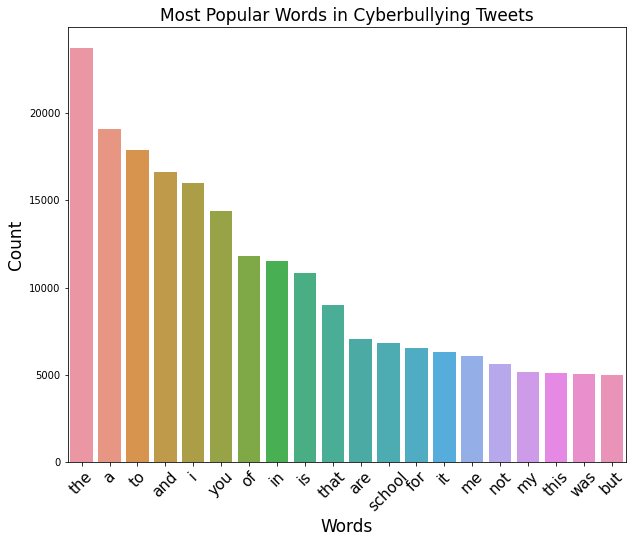

In [23]:
#creating dataframe of most popular words in cyberbullying tweets for train set
top_words_list  = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
top_words_list= [[word ,value] for word, value in top_words_list[0:20]]
top_words_df=pd.DataFrame(top_words_list, columns=["Words", "Word_Count"])

#plotting 20 most popular words
plt.figure(figsize=(10,8))
sns.barplot(x="Words", y= "Word_Count", data=top_words_df)
plt.title("Most Popular Words in Cyberbullying Tweets", fontsize=17)
plt.xlabel("Words",fontsize=17)
plt.ylabel("Count",fontsize=17)
plt.xticks(rotation = 45)
plt.xticks(fontsize=15)

In [24]:
#Tokenizing the text in the train set observations
tokenized_sentences = tokenizer.texts_to_sequences(X_train)

#counting the number of tokens in each observation
number_of_tokens_in_each_sentence=[len(sequence) for sequence in tokenized_sentences]

In [28]:
print("The minimum # of tokens in the Cyberbullying Tweets is: {}".format(min(number_of_tokens_in_each_sentence)))
print("The maximum # of tokens in the Cyberbullying Tweets is: {}".format(max(number_of_tokens_in_each_sentence)))
print("The average # of tokens in the Cyberbullying Tweets is: {}".format(np.round(np.mean(number_of_tokens_in_each_sentence),3)))
print("The 99.95 percentile of # tokens in the Cyberbullying Tweets is: {}".format(np.round(np.quantile(number_of_tokens_in_each_sentence,0.995),3)))      


The minimum # of tokens in the Cyberbullying Tweets is: 0
The maximum # of tokens in the Cyberbullying Tweets is: 787
The average # of tokens in the Cyberbullying Tweets is: 24.174
The 99.95 percentile of # tokens in the Cyberbullying Tweets is: 57.0


(0.0, 100.0)

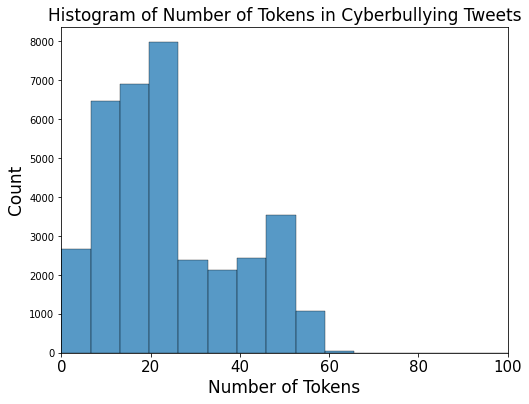

In [30]:
#histogram of tokens in cyberbullying tweets
plt.figure(figsize=(8,6))
sns.histplot(x=number_of_tokens_in_each_sentence, bins=120)
plt.title("Histogram of Number of Tokens in Cyberbullying Tweets", fontsize=17)
plt.xlabel("Number of Tokens",fontsize=17)
plt.ylabel("Count",fontsize=17)
plt.xticks(fontsize=15)
plt.xlim(0,100)

(0.0, 300.0)

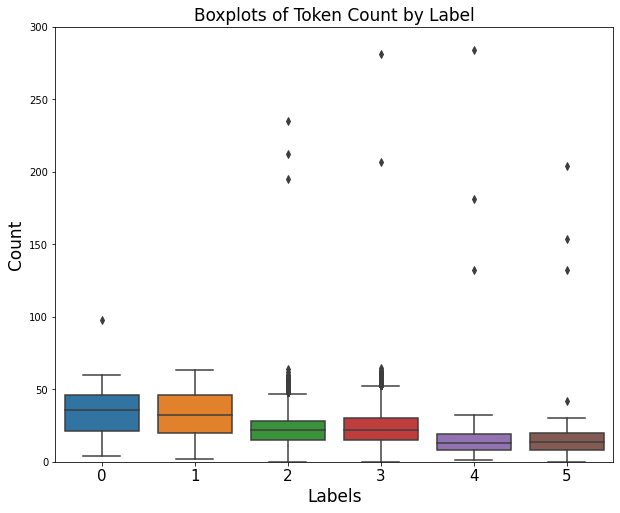

In [32]:
#adding # of tokens in each observation to the dataframe
X_Y_train=X_train.copy()
X_Y_train["label_names"]=y_train
X_Y_train["num_tokens"]= number_of_tokens_in_each_sentence

#Creating Boxplots of number of tokens in observations per label.
#would not be a good predictor as the ranges of the boxplots overlap heavily for the pairs 0 and 1, 2 and 3 and 4 and .
plt.figure(figsize=(10,8))
sns.boxplot(x="label_names", y="num_tokens", data=X_Y_train)
plt.title("Boxplots of Token Count by Label", fontsize=17)
plt.xlabel("Labels",fontsize=17)
plt.ylabel("Count",fontsize=17)
plt.xticks(fontsize=15)

plt.ylim(0,300)